# HWAI Project

Import section

In [1]:
import sys, os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras import layers, optimizers
from keras.applications import MobileNetV2
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import visualkeras, logging

# my import
from modules import models

#suppress warnings
tf.get_logger().setLevel(logging.ERROR)

2023-04-18 18:41:00.098602: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-18 18:41:00.722864: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
IMAGESIZE = 128 #TODO: Check arduino cam size
DATADIR = "/home/mattiamorabito/Documents/HwAi/dataset/"
DATADIRT = "/home/mattiamorabito/Documents/HwAi/testing/"

#tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Check if GPU is mounted

In [3]:
device_name = tf.test.gpu_device_name()
print(device_name)
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

/device:GPU:0
Found GPU at: /device:GPU:0


2023-04-18 16:27:15.683627: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 16:27:16.007251: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-04-18 16:27:16.007636: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model Definition

In [5]:
def build_model():
    mobilenet =tf.keras.applications.MobileNetV3Small(
        input_shape=(IMAGESIZE,IMAGESIZE,3),
        alpha=1.0,
        minimalistic=True,
        include_top=False,
        weights='imagenet'
    )
    model = Sequential()
    model.add(mobilenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(16, activation='softmax'))
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.00002),
        metrics=['accuracy']
    )
    
    return model

def deep_tiny():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGESIZE,IMAGESIZE,3)))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(16, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(8, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='softmax'))
    model.compile(
          loss='categorical_crossentropy',
          optimizer=optimizers.Adam(learning_rate=0.00001),
          metrics=['accuracy']
      )
    return model

def deep_tiny_x5():
    model = Sequential()
    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(IMAGESIZE,IMAGESIZE,3)))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(8, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='softmax'))
    model.compile(
          loss='categorical_crossentropy',
          optimizer=optimizers.Adam(learning_rate=0.00001),
          metrics=['accuracy']
      )
    return model

def deep_tiny_x5_xl():
    model = Sequential()

    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(IMAGESIZE,IMAGESIZE,3)))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(32, (5, 5), activation='relu', input_shape=(IMAGESIZE,IMAGESIZE,3)))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(32, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(16, (5, 5), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(32, activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='softmax'))
    model.compile(
          loss='categorical_crossentropy',
          optimizer=optimizers.Adam(learning_rate=0.00001),
          metrics=['accuracy']
      )
    return model

def teensy_model():
    model = Sequential()
    model.add(layers.Conv2D(48, (3, 3), activation='relu', input_shape=(IMAGESIZE,IMAGESIZE,3)))
    model.add(layers.MaxPooling2D((2, 2),strides=(2, 2)))

    model.add(layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((4, 4),strides=(4, 4)))

    model.add(layers.Flatten())

    model.add(layers.Dense(24, activation='relu'))
    model.add(layers.Dropout(0.15))

    model.add(layers.Dense(16, activation='softmax'))
    model.compile(
          loss='categorical_crossentropy',
          optimizer=optimizers.Adam(learning_rate=0.00001),
          metrics=['accuracy']
      )
    return model

def vanilla_mobilenet():
    model = tf.keras.applications.mobilenet_v2.MobileNetV2(
      input_shape=(IMAGESIZE,IMAGESIZE,3),
      alpha=1.0,
      include_top=True,
      weights=None,
      classes=30,
      classifier_activation='softmax'
      )
    model.compile(
          loss='categorical_crossentropy',
          optimizer=optimizers.Adam(learning_rate=0.00002),
          metrics=['accuracy']
      )
    return model
def le_net_model():
    model = Sequential()
    model.add(layers.Conv2D(6, 5, activation= 'tanh', input_shape=(IMAGESIZE,IMAGESIZE,3)))
    model.add(layers.AveragePooling2D (2))
    model.add(layers.Activation('sigmoid'))
    model.add(layers.Conv2D(16, 5, activation= 'tanh')) 
    model.add(layers.AveragePooling2D(2))
    model.add(layers.Activation('sigmoid'))
    model.add(layers.Conv2D(120, 5, activation= 'tanh'))
    model.add(layers.Flatten())
    model.add(layers.Dense(84, activation= 'tanh')) 
    model.add(layers.Dense(30, activation='softmax'))

    model.compile(
        loss='categorical_crossentropy',
        optimizer=optimizers.Adam(learning_rate=0.00001),
        metrics=['accuracy']
    )
    return model

Loading dataset

In [29]:
#train_ds = [1,2]
#Load training set
#train_ds[0] = tf.keras.utils.image_dataset_from_directory(DATADIR,labels='inferred',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))
#Load validation set
#train_ds[1] = tf.keras.utils.image_dataset_from_directory(DATADIRV,labels='inferred',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))
normalization_layer = tf.keras.layers.Rescaling(1./255)

#small dataset to run tests
train_ds = tf.keras.utils.image_dataset_from_directory(DATADIR,seed = 2,labels='inferred',validation_split=.15,subset='both',label_mode='categorical',shuffle=True,image_size=(IMAGESIZE, IMAGESIZE))

train_ds[0] = train_ds[0].map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)    # cache and prefetch of the first element (the training set)
train_ds[1] = train_ds[1].map(lambda x, y: (normalization_layer(x), y)).cache().prefetch(buffer_size=tf.data.AUTOTUNE)


Found 19419 files belonging to 16 classes.
Using 16507 files for training.
Using 2912 files for validation.
<class 'list'> [<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>, <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 16), dtype=tf.float32, name=None))>]


Model instances and visualization

In [30]:
# Train Model    
model = models.deep_tiny_x5_xl()
#model = models.minimalmodel()
model.summary()
visualkeras.layered_view(model,legend=True).show() # display using your system viewer

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 25, 25, 32)        25632     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 32)      

Model training

In [31]:
checkpoint = ModelCheckpoint('savedmodels/deep_tiny_180423.h5', save_best_only=True)
with tf.device('/GPU:0'):
    history = model.fit(
        train_ds[0],
        epochs=100,
        batch_size=32,
        callbacks=[
            checkpoint,
            tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=20, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.8, min_lr=1e-6)
            ],
        validation_data=train_ds[1]
    )

Epoch 1/100


2023-04-18 17:47:52.414655: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [16507]
	 [[{{node Placeholder/_0}}]]
2023-04-18 17:47:52.415231: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [16507]
	 [[{{node Placeholder/_4}}]]


515/516 [============================>.] - ETA: 0s - loss: 2.7605 - accuracy: 0.0734

2023-04-18 17:48:08.174536: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2912]
	 [[{{node Placeholder/_4}}]]
2023-04-18 17:48:08.175166: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [2912]
	 [[{{node Placeholder/_4}}]]


516/516 [==============================] - 17s 33ms/step - loss: 2.7604 - accuracy: 0.0735 - val_loss: 2.7448 - val_accuracy: 0.0944 - lr: 1.0000e-05
Epoch 2/100
516/516 [==============================] - 15s 30ms/step - loss: 2.7342 - accuracy: 0.0970 - val_loss: 2.7078 - val_accuracy: 0.1463 - lr: 1.0000e-05
Epoch 3/100
516/516 [==============================] - 15s 30ms/step - loss: 2.7029 - accuracy: 0.1176 - val_loss: 2.6663 - val_accuracy: 0.1720 - lr: 1.0000e-05
Epoch 4/100
516/516 [==============================] - 16s 30ms/step - loss: 2.6594 - accuracy: 0.1335 - val_loss: 2.5948 - val_accuracy: 0.1762 - lr: 1.0000e-05
Epoch 5/100
516/516 [==============================] - 15s 30ms/step - loss: 2.5972 - accuracy: 0.1574 - val_loss: 2.5222 - val_accuracy: 0.1927 - lr: 1.0000e-05
Epoch 6/100
516/516 [==============================] - 17s 33ms/step - loss: 2.5420 - accuracy: 0.1709 - val_loss: 2.4535 - val_accuracy: 0.2194 - lr: 1.0000e-05
Epoch 7/100
516/516 [===================

Various Graph

Evaluate
Found 694 files belonging to 16 classes.


  0%|          | 0/35 [00:00<?, ?it/s]2023-04-18 17:41:25.982048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_4' with dtype int32 and shape [694]
	 [[{{node Placeholder/_4}}]]
2023-04-18 17:41:25.982320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [694]
	 [[{{node Placeholder/_0}}]]
100%|██████████| 35/35 [00:01<00:00, 18.56it/s]


0.3025936599423631


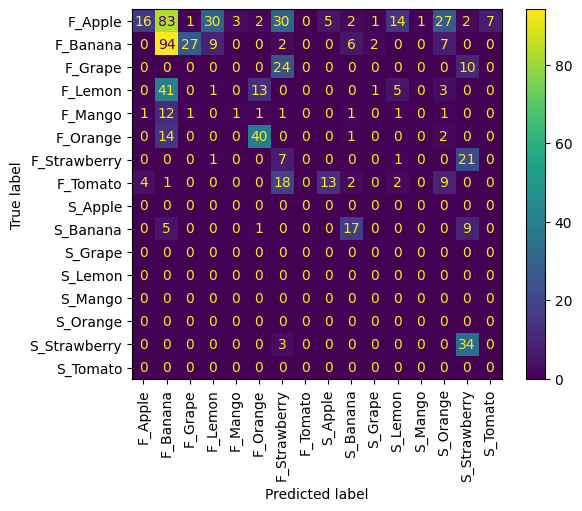

In [25]:
print("Evaluate")
#load test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(DATADIRT,labels='inferred',batch_size=20,label_mode='categorical',image_size=(IMAGESIZE, IMAGESIZE))

#extract class names
classes = test_dataset.class_names

#rescale
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

#get predictions
predictions = np.array([])
labels =  np.array([])
for x, y in tqdm(test_dataset):
  # selecet the class for which i have the max confidence
  predictions = np.concatenate([predictions, np.argmax(model.predict(x,verbose=0), axis = -1)])
  labels = np.concatenate([labels, np.argmax(y.numpy(), axis=-1)])

print(accuracy_score(labels, predictions))
t = confusion_matrix(labels, predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=t,display_labels=classes)
disp.plot(xticks_rotation='vertical')
plt.show()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 124, 124, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 62, 62, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 58, 58, 32)        25632     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 29, 29, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 25, 25, 32)        25632     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 12, 12, 32)       0

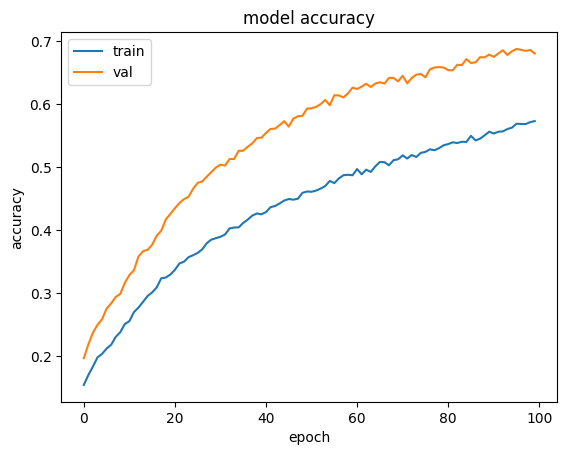

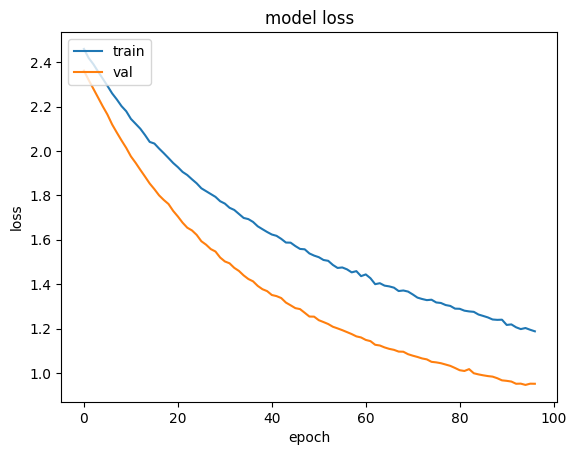

In [26]:
#model = tf.keras.models.load_model('savedmodels/deep_tiny_x5_xl.h5')
visualkeras.layered_view(model,legend=True).show() # display using your system viewer
model.summary()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(history.history['loss'][3:])
plt.plot(history.history['val_loss'][3:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Weight distrubution

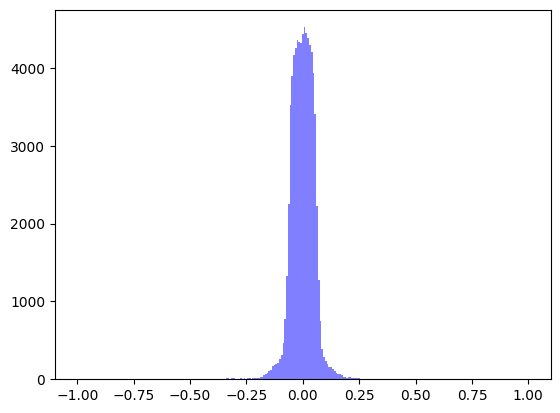

In [30]:
all_wi = []
wi = model.weights
for elem in wi:
  var = list(elem.read_value().numpy().flatten())
  all_wi= all_wi +var
s = np.array(all_wi)
sbins = np.linspace(-1,1,256)
plt.hist(s, bins=sbins, facecolor='blue', alpha=0.5)
plt.show()